This goes through the general pipeline to analyze the ATP calibrations for ATEAM.

Here I am using AT1.03 full-field with motors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [3]:
import atp_cal

In [4]:
atp_cal.pboc_style_mpl()

# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

## Settings and Functions

#### Image Plotting Settings

In this cell I specify the size of images and the conversion of pixels to µm. As well as, some settings for plotting in holoviews

In [5]:
# Length calibration [microns per pixel]
um_per_pixel = 0.29

# Image dimensions
w_px, h_px = 1920, 1200
w_um, h_um = w_px*um_per_pixel, h_px*um_per_pixel

#bounds
bounds = [0, 0, w_um, h_um]

#Set the frame size of the image to enforce square pixels (holoviews does not have this preset)
frame_height = 200
frame_width = w_px * frame_height // h_px

#Preset these settings as opts
opts = dict(
    frame_height=frame_height,
    frame_width=frame_width,
    xlabel="µm",
    ylabel="µm",
    cmap = 'viridis'
)

#### Parameters:
Here list ATP concentration

In [6]:
ATPconc = np.array([1410, 705, 352, 176, 88, 0])

## Import Images

In [7]:
#This should not change between experiments:
datapath = '../../../../data/atp_cal'

#This varies between experiments. Here I use the calibration from 5/23/22. 
datafolder = '2022-06-29_ATeam_Cal/2022-06-29_ATeam_Cal_1/images'

# YFP Images
included_YFP = '*C1*.tif'
YFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_YFP))

# CFP Images
included_CFP = '*C2*.tif'
CFP_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_CFP))

# Motor Images
included_Mot = '*C3*.tif'
Mot_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_Mot))

#The ensure images are in order, sort them:
YFP_files_ordered = atp_cal.file_sorter(YFP_files)
CFP_files_ordered = atp_cal.file_sorter(CFP_files)
Mot_files_ordered = atp_cal.file_sorter(Mot_files)

#Read in images and save as array:
YFP_array = atp_cal.file_to_image(YFP_files_ordered)
CFP_array = atp_cal.file_to_image(CFP_files_ordered)
Mot_array = atp_cal.file_to_image(Mot_files_ordered)

# Define the zero concentration image (DO EVERY TIME):
YFP_zero = YFP_array[0] #[-2]
CFP_zero = CFP_array[0] #[-2]
Mot_zero = Mot_array[0] #[-2]

# ------------------------------------------------------------------------------ #

#Import Background images
bgfolder = '2022-06-29_ATeam_Cal/2022-06-29_ATeam_Cal_1/images'

bgYFP_name = 'C1-2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome'
bgCFP_name = 'C2-2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome'
bgMot_name = 'C3-2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome'

#2022-06-29_ATeam_Cal_1_MMStack_Pos6.ome0000

#YFP_bg = atp_cal.file_to_image(np.sort(glob.glob(datapath+'/'+bgfolder+'/'+bgYFP_name)))
YFP_bg = skimage.io.imread(datapath+'/'+bgfolder+'/'+bgYFP_name+'.tif')
CFP_bg = skimage.io.imread(datapath+'/'+bgfolder+'/'+bgCFP_name+'.tif')
Mot_bg = skimage.io.imread(datapath+'/'+bgfolder+'/'+bgMot_name+'.tif')

# Define an average offset
YFP_bg_offset = np.average(YFP_bg)
CFP_bg_offset = np.average(CFP_bg)
Mot_bg_offset = np.average(Mot_bg)

In [8]:
#delete the 7th image that is 0uM ATP with no ATeam (this is the bg images imported above)
YFP_array = YFP_array[:-1]
CFP_array = CFP_array[:-1]
Mot_array = Mot_array[:-1]

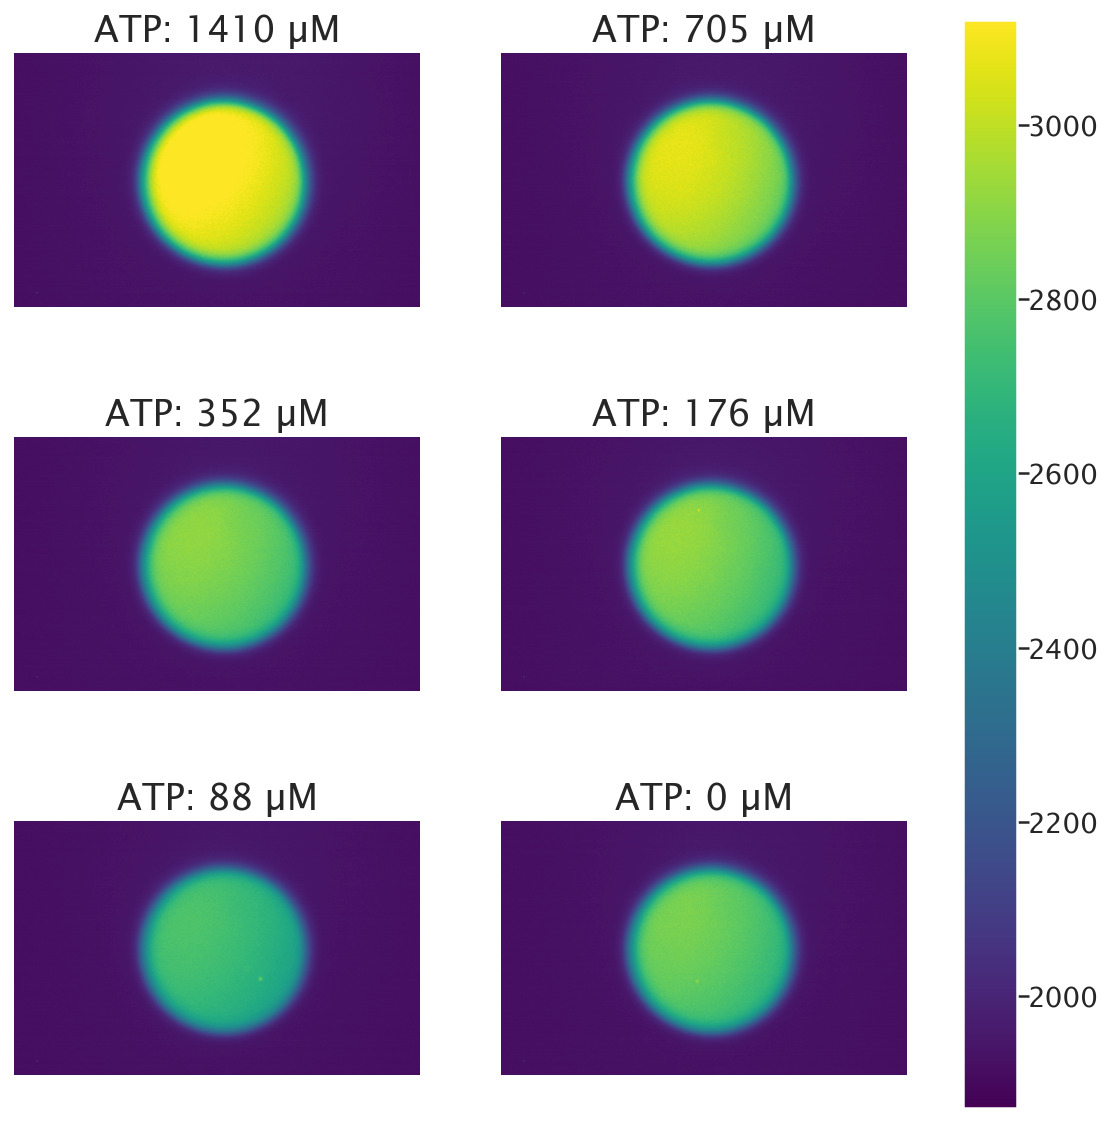

In [9]:
array_to_plot = YFP_array
colorbar_min = np.percentile(YFP_zero, 0)
colorbar_max = np.percentile(array_to_plot, 99)

#The rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
    
else:
    plot_array = array_to_plot
    plot_ATPconc = ATPconc

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()


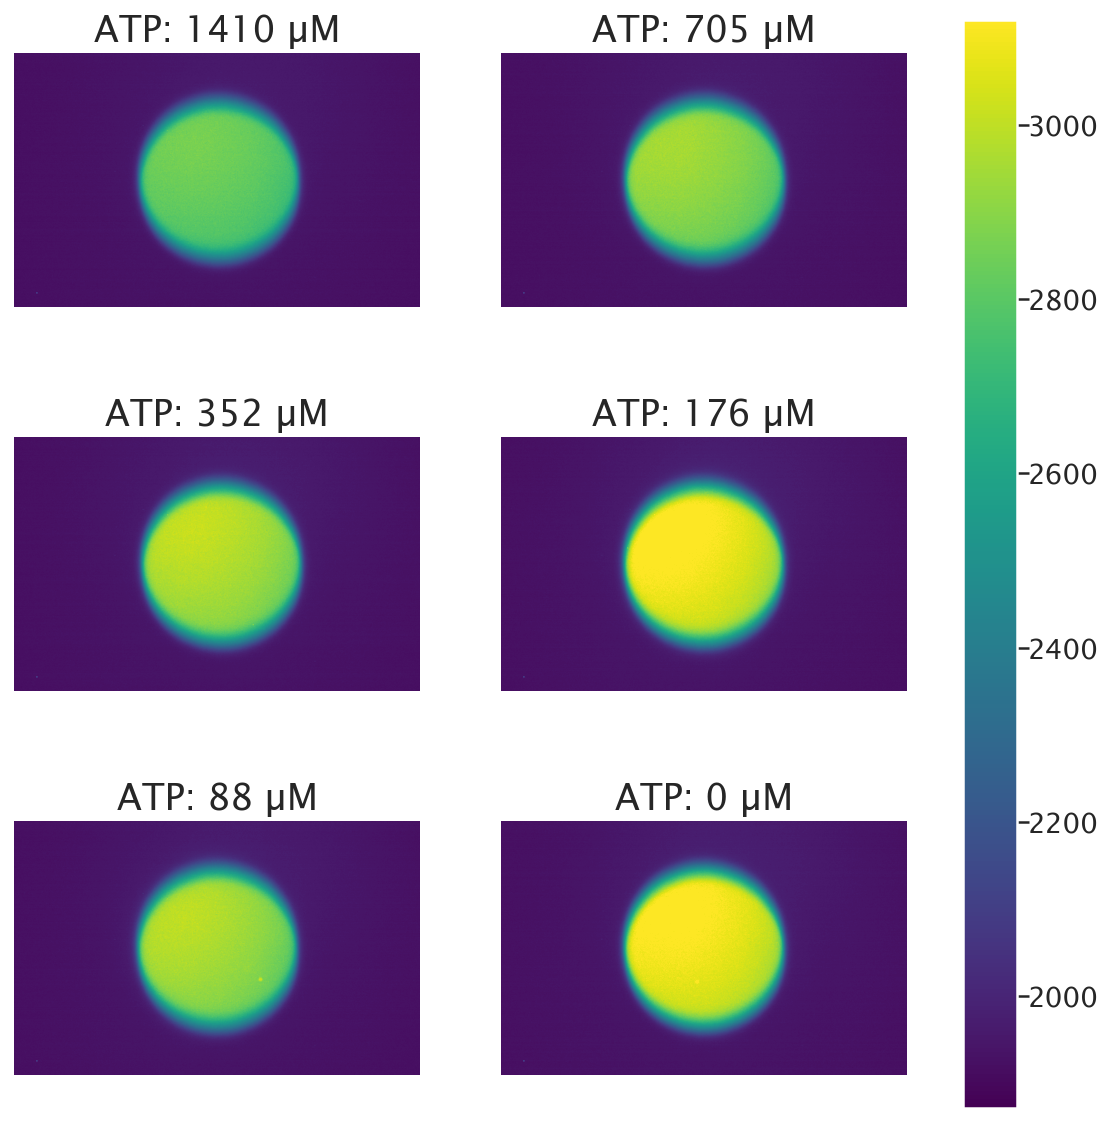

In [10]:
array_to_plot = CFP_array
colorbar_min = np.percentile(CFP_zero, 0)
colorbar_max = np.percentile(array_to_plot, 99)

#The rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
    
else:
    plot_array = array_to_plot

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()


## Subtract background and correct for uneven illumination background subtraction

In [11]:
#Subtract im_dark from all calibration images
YFP_bs = YFP_array - YFP_bg
CFP_bs = CFP_array - CFP_bg
Mot_bs = Mot_array - Mot_bg

In [12]:
CFP_bs[CFP_bs<0] = 0
YFP_bs[CFP_bs<0] = 0
Mot_bs[CFP_bs<0] = 0

## Bianary image circular mask:

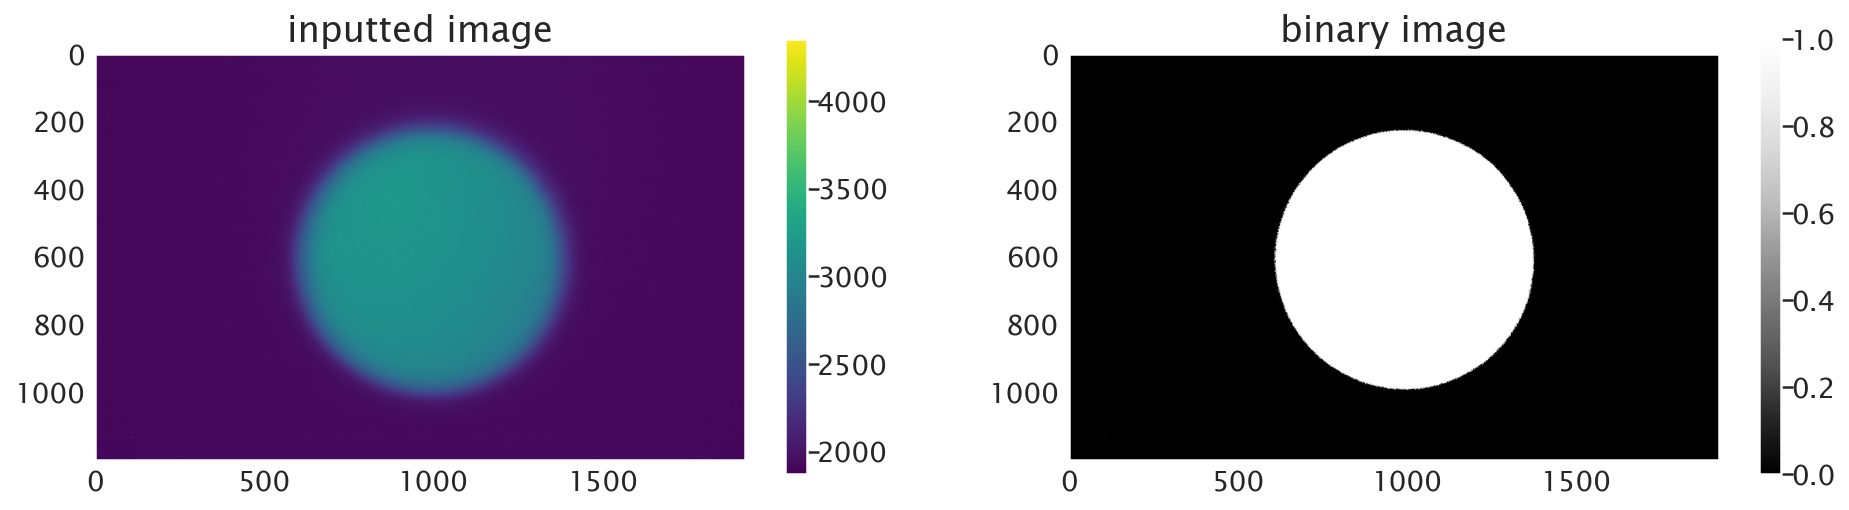

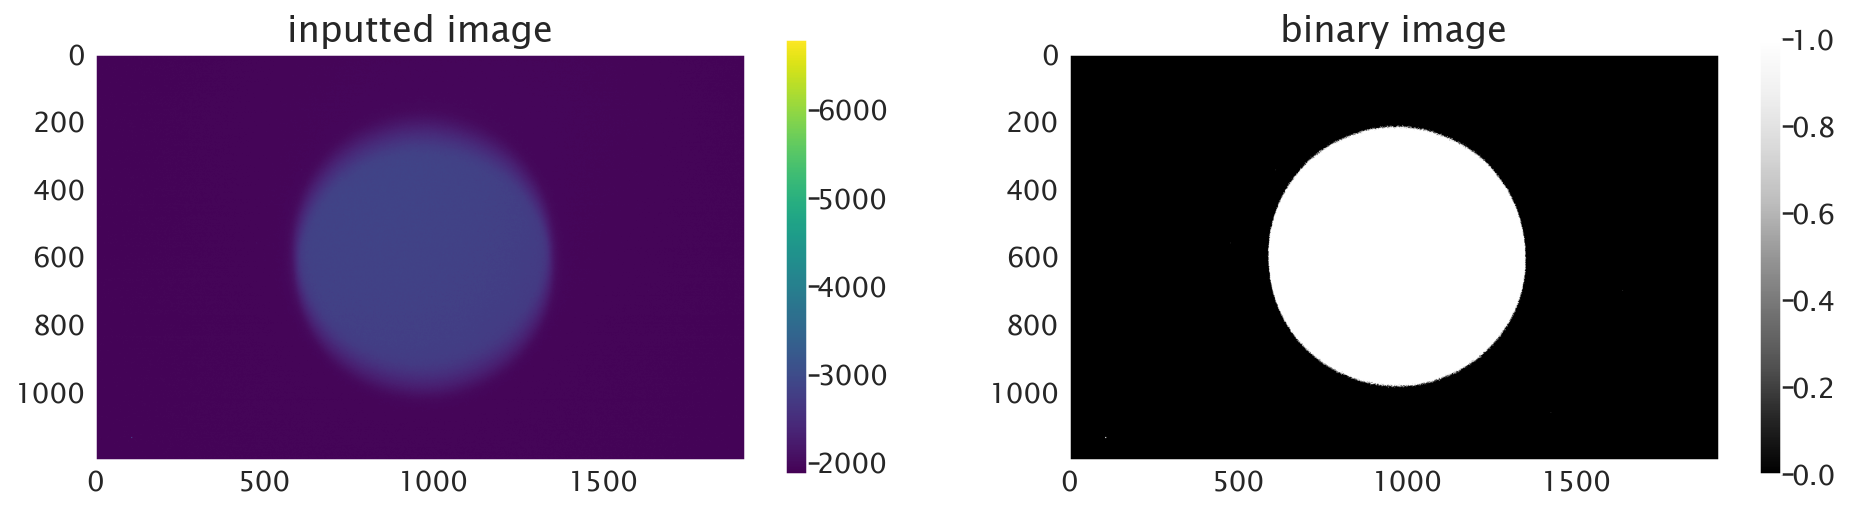

In [13]:
im_binary_YFP = atp_cal.binary_im_generator(YFP_array[0])
im_binary_CFP = atp_cal.binary_im_generator(CFP_array[0])

In [14]:
YFP_bin = YFP_bs*im_binary_YFP
CFP_bin = CFP_bs*im_binary_CFP
Mot_bin = Mot_bs*im_binary_YFP

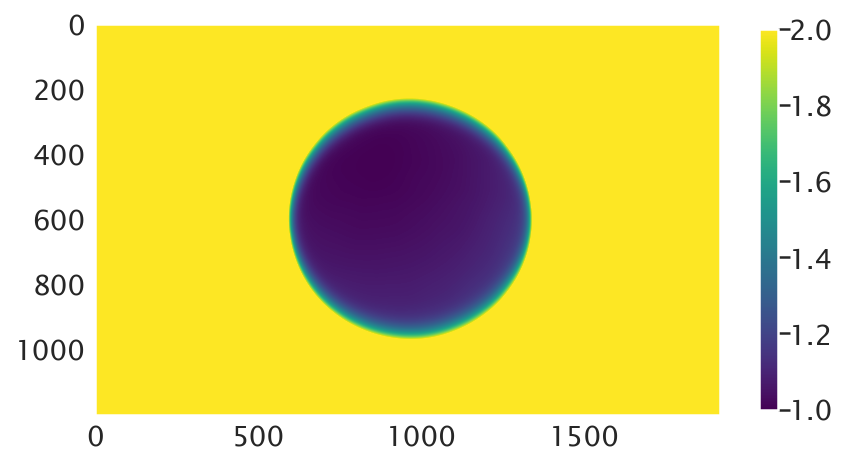

In [15]:
#Find the normilization matrix
YFP_norm_mat = atp_cal.norm_mat_fn_iATP(YFP_zero, YFP_bg_offset)
CFP_norm_mat = atp_cal.norm_mat_fn_iATP(CFP_zero, CFP_bg_offset)
Mot_norm_mat = atp_cal.norm_mat_fn_iATP(Mot_zero, Mot_bg_offset)

#plot the normalizaiton matrix
plt.imshow(CFP_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)
plt.grid(False)

In [16]:
#Normalize all the claibration images by multiplying by the normalization matrix
YFP_norm = YFP_bin*YFP_norm_mat
CFP_norm = CFP_bin*CFP_norm_mat
Mot_norm = Mot_bin*Mot_norm_mat

In [17]:
print(CFP_bs.min())
print(CFP_norm_mat.min())
print(CFP_bin.min())
print(YFP_bs.min())
print(YFP_norm_mat.min())
print(YFP_bin.min())

0
1.0000032752415782
0
-80
1.0000011501845099
0


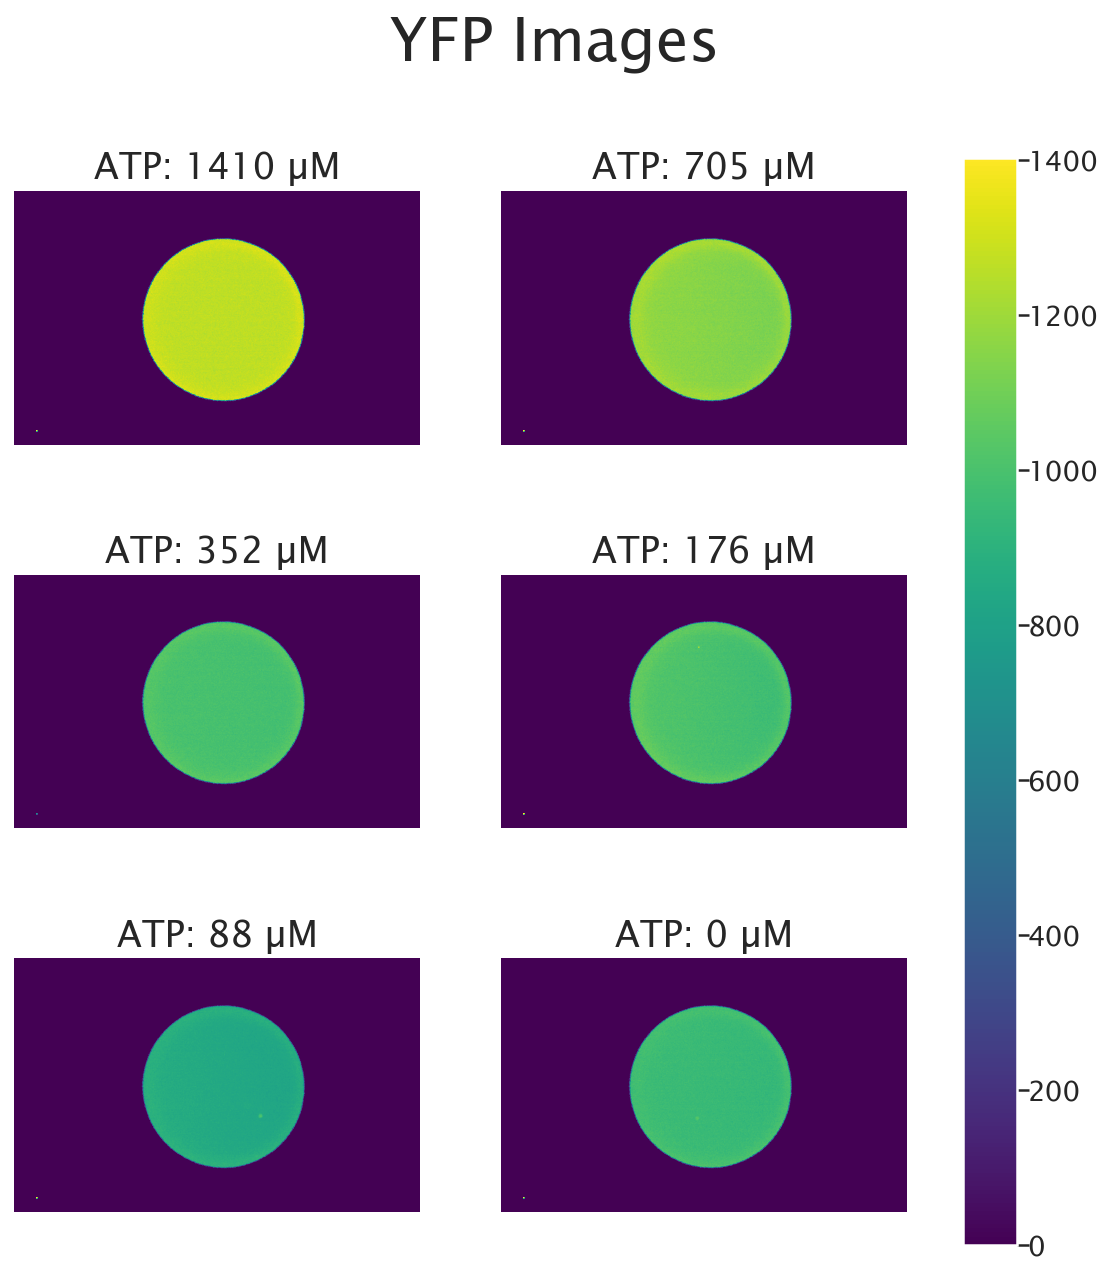

In [18]:
array_to_plot = YFP_norm
colorbar_min = np.percentile(array_to_plot, 0)
colorbar_max = np.percentile(array_to_plot, 99.99)

#Rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
else:
    plot_array = array_to_plot

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
plt.suptitle('YFP Images', fontsize=30)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

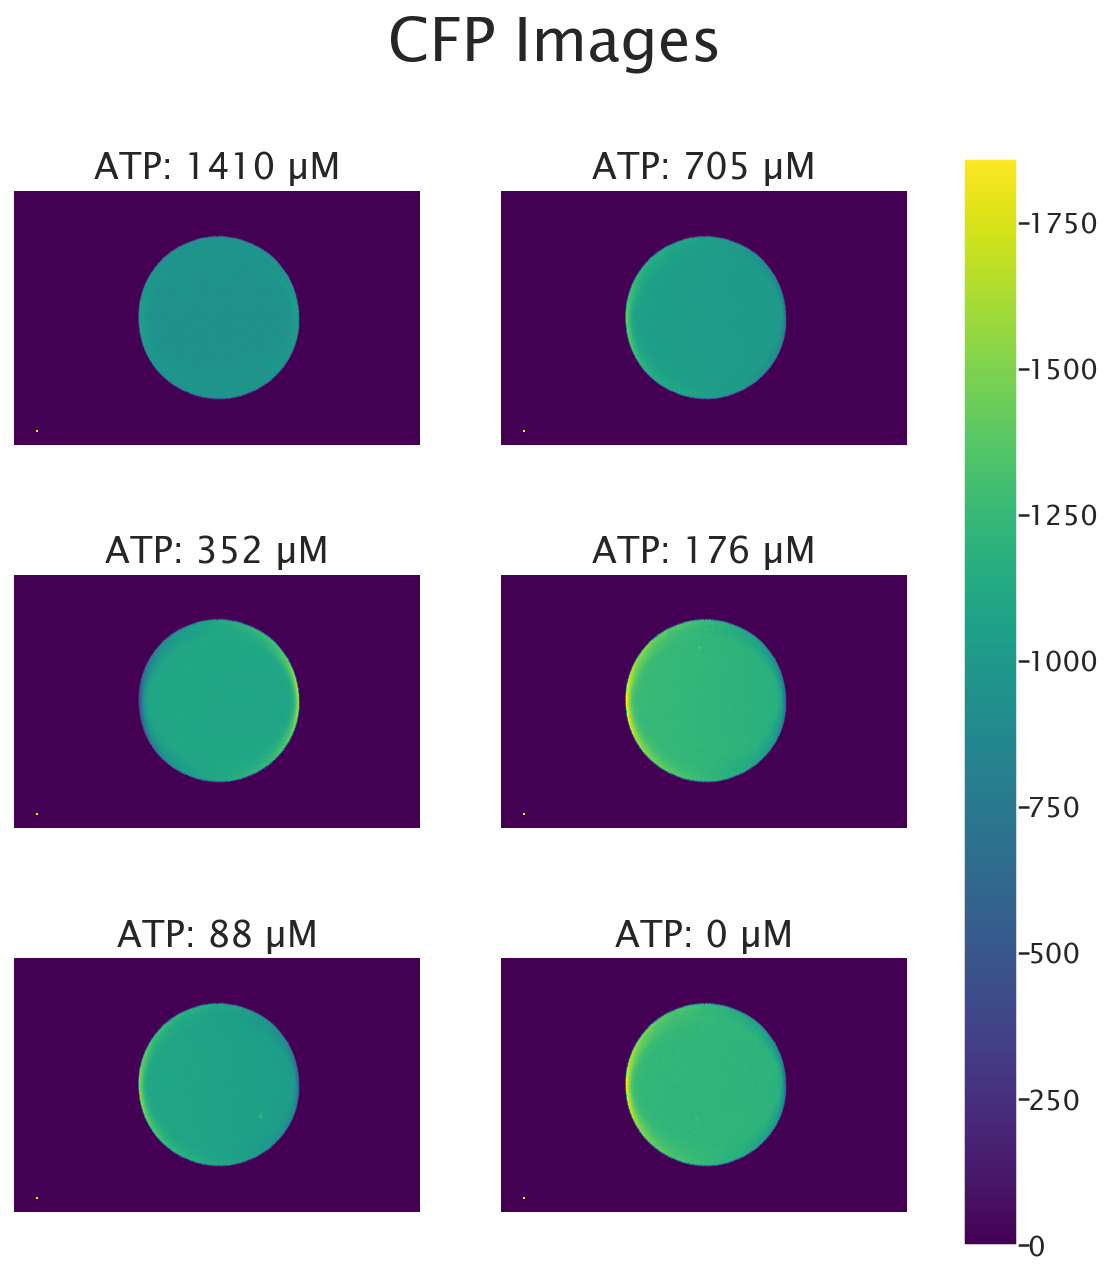

In [19]:
array_to_plot = CFP_norm
colorbar_min = np.percentile(array_to_plot, 0)
colorbar_max = np.percentile(array_to_plot, 99.99)

#Rest is automated
if len(array_to_plot)%2 != 0:
    plot_array = np.concatenate((array_to_plot, np.zeros((1, 1200, 1920))))
    plot_ATPconc = np.concatenate((ATPconc, np.array(['filler'])))
else:
    plot_array = array_to_plot

fig, axes = plt.subplots(nrows=int((len(plot_array)+1)/2), ncols=2, figsize = (10, 10))

cmap=cm.get_cmap('viridis')
normalizer=Normalize(colorbar_min, colorbar_max)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow((plot_array[i]),cmap=cmap,norm=normalizer)
    ax.set_title('ATP: ' + str(plot_ATPconc[i]) + ' µM')
    ax.axis('off')
    
plt.suptitle('CFP Images', fontsize=30)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

### Add in a crop so that edge effects dont matter

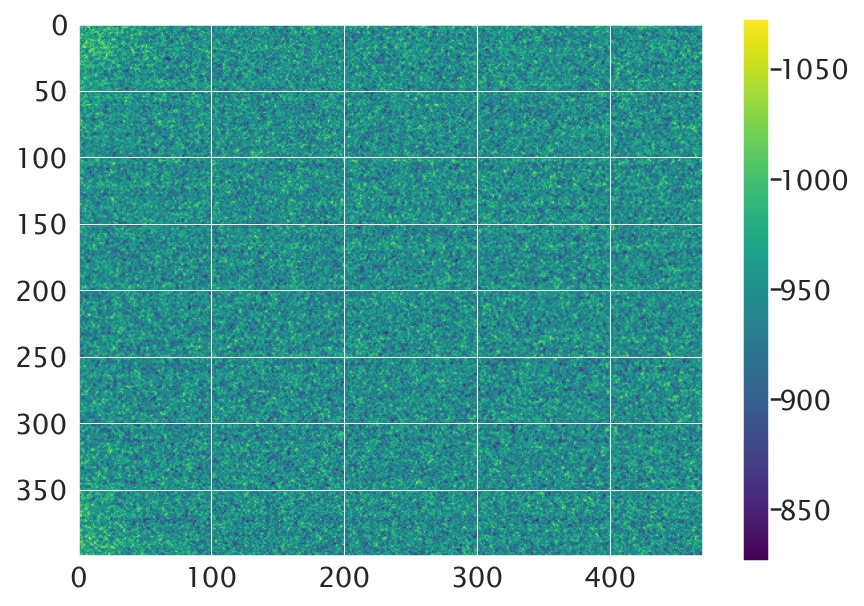

In [20]:
plt.imshow(CFP_norm[0] [400:800, 680:1150])#[400:800, 760:1160])
plt.colorbar()

In [21]:
crop = np.s_[400:800, 680:1150]

In [22]:
for i in range(len(YFP_norm)):
    im = YFP_norm[i][crop]/CFP_norm[i][crop]
    im[np.where(im==np.inf)] = 0
    mintest = round(np.min(im),2)
    maxtest = round(np.max(im),2)
    meantest = round(np.nanmean(im[np.nonzero(im)]),2)
    print('min: ' + str(mintest) + '   max: ' + str(maxtest) + '   mean: ' + str(meantest))
                                                                                                         

min: 1.12   max: 1.6   mean: 1.34
min: 0.92   max: 1.34   mean: 1.12
min: 0.75   max: 1.16   mean: 0.91
min: 0.66   max: 0.97   mean: 0.82
min: 0.64   max: 0.99   mean: 0.79
min: 0.63   max: 0.93   mean: 0.78


## Calculate the average intensity value per concentration

In [23]:
#Average over the non-zero values in the image to get the calibration
YFP_calavg = np.empty(len(YFP_norm))
for i, im in enumerate(YFP_norm):
    im = im[crop]
    YFP_calavg[i] = np.average(im[np.nonzero(im)])
    
CFP_calavg = np.empty(len(CFP_norm))
for i, im in enumerate(CFP_norm):
    im = im[crop]
    CFP_calavg[i] = np.average(im[np.nonzero(im)])
    
#ratio_calavg = YFP_calavg/CFP_calavg

ratio_calavg = np.empty(len(YFP_norm))
for i in range(len(YFP_norm)):
    im = YFP_norm[i][crop]/CFP_norm[i][crop]
    im[np.where(im==np.inf)] = 0
    ratio_calavg[i] = np.nanmean(im[np.nonzero(im)])
    
Mot_calavg = np.empty(len(Mot_norm))
for i, im in enumerate(Mot_norm):
    Mot_calavg[i] = np.average(im[np.nonzero(im)])

In [24]:
print(YFP_calavg)
print(' ')
print(CFP_calavg)
print(' ')
print(ratio_calavg)
print(' ')

[1267.33697514 1155.56758213  996.26137997 1004.78970613  853.52766044
  952.18542603]
 
[ 948.4343753  1034.87456233 1096.46515952 1229.82828506 1076.41549151
 1223.0967776 ]
 
[1.33758691 1.11760708 0.90941189 0.81759123 0.79360997 0.77909067]
 


## Plot the data and fit to a Hill function

In [25]:
#Langmuir equation
def ATeam_Hill(conc, a, b, c, d):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)**d/(1+(conc/a)**d))+c)



#Curve-fit to the Langmuir curve
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 4 entries of parameter guesses for a, b, c, and d in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(4), np.ones([4])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2], param[3])
    
    return param, curve, xvals

[742.35821458   1.49020742   0.78121991   2.01749055]


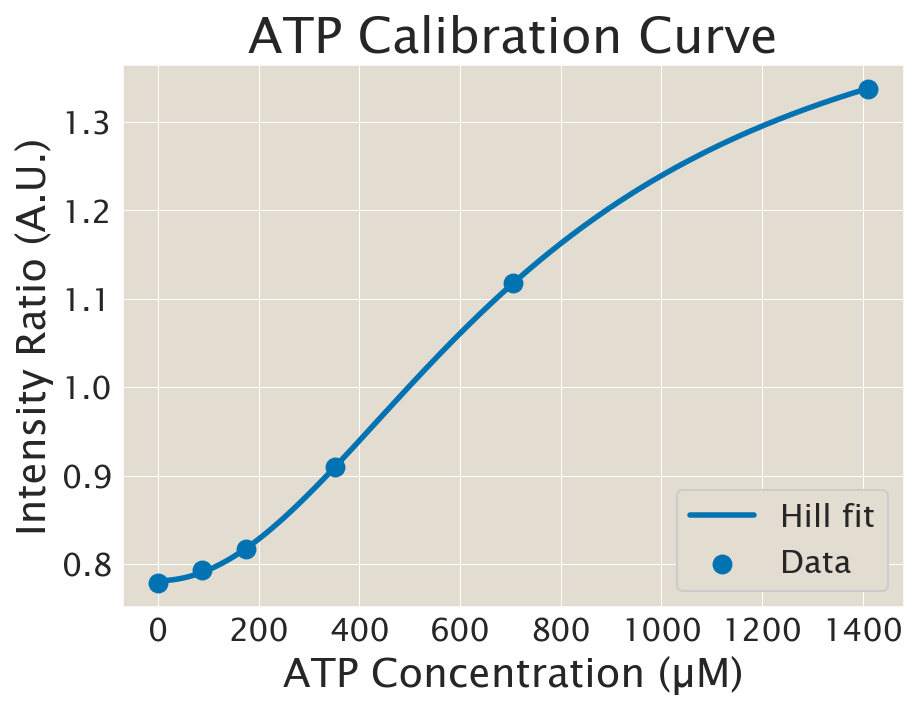

In [52]:
params, curve, xvals = ATeam_Hill_curve_fit(ATPconc[:], ratio_calavg[:], ATPconc[0], [300, 1, 0.5, 7])
print(params)

fig, axes = plt.subplots()

plt.scatter(ATPconc[:], ratio_calavg[:], label = 'Data', s=80)
#plt.xscale('log')
plt.plot(xvals, curve, label='Hill fit', linewidth = 2.75)
plt.legend(loc = 'lower right', fontsize = 16)
plt.xlabel('ATP Concentration (µM)', fontsize = 20)
plt.ylabel('Intensity Ratio (A.U.)', fontsize = 20)
plt.title('ATP Calibration Curve', fontsize = 25)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
fig.savefig('2022-06-29_ATeam_Cal_1--Kd=742_Rr=1.49_Rm=0.78_n=2.02.png', dpi=300)